## **DEMANDA Y TEMPERATURA:** INFERENCIA Y ANOVA

#### **1) Importamos libreria útiles:**

In [106]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate

sns.set(style="darkgrid")
maxScatter = 3000

#### **2) Cargamos datos:**

- Comprobamos que trabajamos en el directorio correcto y cargamos datos de carpeta "data":

In [107]:
dir = os.getcwd()
DIR = dir
print('Current working directory:', os.getcwd())


# Nos guardamos los datos que queremos en un dataframe usando pandas
dataframe = pd.read_csv('..\data\G02_DATOS_DEM_G1.csv', sep=',', verbose=True)
dataframe['FECHA'] = pd.to_datetime(dataframe['FECHA'], format='%d/%m/%Y')

def permutar_DIASEM(x):
    return (x + 5) % 7 + 1

dataframe['DIASEM'] = dataframe['DIASEM'].apply(permutar_DIASEM)
dataframe

Current working directory: c:\Users\serov\Documents\GitHub\TRABAJO-1-ESTADISTICA-DESCRIPTIVA\notebooks
Tokenization took: 1.00 ms
Type conversion took: 1.97 ms
Parser memory cleanup took: 0.00 ms


,FECHA,DEM,TMAX,TMIN,FEST,ANNO,MES,DIA,DIASEM
0,2014-01-01,695.150000,14.500000,4.900000,1,2014,1,1,3
1,2014-01-02,848.520000,17.900000,8.300000,0,2014,1,2,4
2,2014-01-03,842.250000,18.000000,10.800000,0,2014,1,3,5
3,2014-01-04,790.870000,14.800000,9.900000,0,2014,1,4,6
4,2014-01-05,765.880000,15.500000,8.300000,0,2014,1,5,7
...,...,...,...,...,...,...,...,...,...
2950,2022-01-29,897.963540,14.928054,7.128469,0,2022,1,29,6
2951,2022-01-30,883.656025,14.921389,7.131950,0,2022,1,30,7
2952,2022-01-31,1016.937007,14.914723,7.135431,0,2022,1,31,1
2953,2022-02-01,1014.929731,14.908058,7.138912,0,2022,2,1,2


#### **3) Estimación TMAX esperada en julio:**

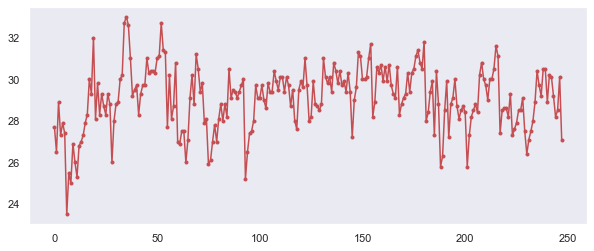

,FECHA,DEM,TMAX,TMIN,FEST,ANNO,MES,DIA,DIASEM
181,2014-07-01,616.210000,27.700000,21.300000,0,2014,7,1,2
182,2014-07-02,621.200000,26.500000,22.400000,0,2014,7,2,3
183,2014-07-03,621.740000,28.900000,21.800000,0,2014,7,3,4
184,2014-07-04,609.110000,27.300000,20.000000,0,2014,7,4,5
185,2014-07-05,513.060000,27.900000,20.000000,0,2014,7,5,6
...,...,...,...,...,...,...,...,...,...
2764,2021-07-27,685.422648,29.200000,22.000000,0,2021,7,27,2
2765,2021-07-28,688.873368,28.200000,23.000000,0,2021,7,28,3
2766,2021-07-29,686.422835,28.500000,21.900000,0,2021,7,29,4
2767,2021-07-30,660.086516,30.100000,23.300000,0,2021,7,30,5


In [108]:
dataframe_julio = dataframe[dataframe['MES'] == 7]
x = np.array(dataframe_julio.TMAX)

fig = plt.figure(1, figsize=(10, 4)) # permite indicar el nº de la figura y las dimensiones (ancho y alto)
plt.plot(x, 'r.-')                  # muestra la variable x en negro, cada valor con un punto conectados por líneas
plt.grid()
plt.show()
dataframe_julio

C:\Users\serov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


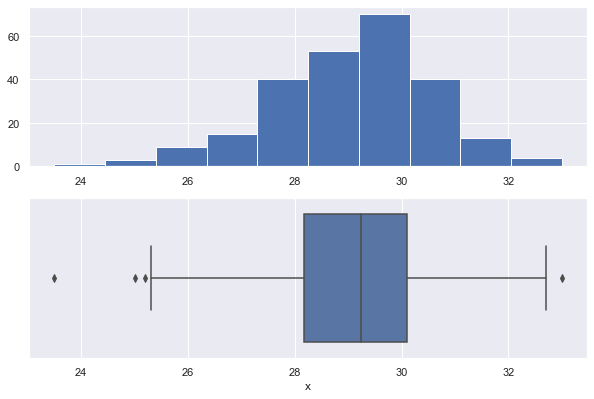

In [109]:
x = np.array(dataframe_julio.TMAX)
# tamaño muestral
n = np.size(x)

fig = plt.figure(1, figsize=(10, 10))
plt.subplot(3,1,1)
plt.hist(x)
plt.subplot(3,1,2)
sns.boxplot(x, orient = 'horizontal')
plt.xlabel('x')
plt.savefig('../reports/figures/Histograma y Boxplot TMAX julio.png', bbox_inches='tight')
plt.show()

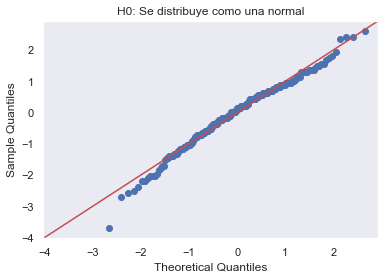

Como vemos no parece que siga una distribución normal
Sin embargo, aunque en los extremos los datos se dispersen, los valores centrales coinciden con los de la normal


In [110]:
# nombre de la distribución teórica que se contrasta (norm, uniform, triang, expon, ...)
distribucion_teo = stats.norm

# genera qqplot de la variable x
sm.qqplot(x, line='45', fit=True, dist=distribucion_teo)
plt.title('H0: Se distribuye como una normal')
plt.savefig('../reports/figures/QQplot julio.png', bbox_inches='tight')
plt.show()
print('Como vemos no parece que siga una distribución normal')
print('Sin embargo, aunque en los extremos los datos se dispersen, los valores centrales coinciden con los de la normal')

Según el test no paramétrico KS se puede afirmar, con un nivel de significación del 5.0%, que los datos de la muestra no siguen una distribución normal, ya que tiene un pvalor de 0.03904386924547959.
Sin embargo, con un nivel de significación inferior, no podríamos rechazar la hipótesis nula


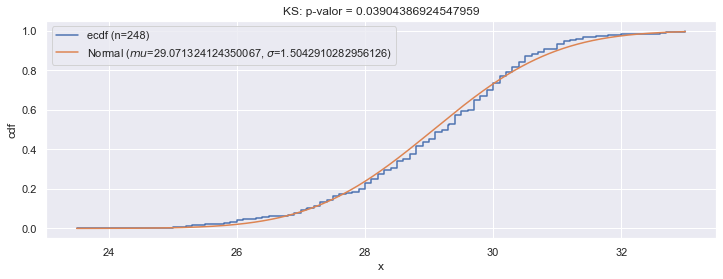

In [111]:
# nivel de significación
alfa = 0.05

# realiza el test
ks = sm.stats.diagnostic.kstest_normal(x, dist='norm', pvalmethod='table')

max_d   = ks[0]
p_valor = ks[1]
print(f'Según el test no paramétrico KS se puede afirmar, con un nivel de significación del {alfa*100}%, que los datos de la muestra no siguen una distribución normal, ya que tiene un pvalor de {p_valor}.')
print('Sin embargo, con un nivel de significación inferior, no podríamos rechazar la hipótesis nula')
# Representación visual del contraste

# estima coefs de la normal
va_teo = stats.norm(np.mean(x), np.std(x))

# calcula acumulada empírica
ecdf = sm.distributions.empirical_distribution.ECDF(x)

# crea gráfica
xs = np.linspace(min(va_teo.ppf(0.01), min(x)), max(va_teo.ppf(1-0.01), max(x)), 1000)

fig = plt.figure(1, figsize=(12, 4))
plt.step(ecdf.x, ecdf.y, label=f'ecdf (n={n})', where='post')
plt.plot(xs, va_teo.cdf(xs), label=f'Normal ($mu$={np.mean(x)}, $\sigma$={np.std(x)})')
# plt.plot([x_max_d,x_max_d], [ecdf.y[index_max_d], va_teo.cdf(x_max_d)], '-r', linewidth=2, label=f'max D = {max_d}, p-value = {p_value}')
plt.title(f'KS: p-valor = {p_valor}')
plt.xlabel('x');plt.ylabel('cdf');plt.legend()
plt.savefig('../reports/figures/KS julio.png', bbox_inches='tight')
plt.show()

In [112]:
#Conclusion
print('Aunque la variable podría seguir una normal, en el qqplot vemos que no termina de aproximarse del todo bien;')
print('Alejándose demasiado de los cuantiles teóricos')
print('Además, por las dudas hacemos un test KS, en el que podemos determinar que solo aproxima a una normal')
print('Para valores de significación inferiores al 4%')
print('Es por ello qu eno arriesgaremos, y utilizaremos el método bootstrap, para el cual no es')
print('necesario hacer ninguna suposición sobre la distribución que sigue la muestra')

Aunque la variable podría seguir una normal, en el qqplot vemos que no termina de aproximarse del todo bien;
Alejándose demasiado de los cuantiles teóricos
Además, por las dudas hacemos un test KS, en el que podemos determinar que solo aproxima a una normal
Para valores de significación inferiores al 4%
Es por ello qu eno arriesgaremos, y utilizaremos el método bootstrap, para el cual no es
necesario hacer ninguna suposición sobre la distribución que sigue la muestra


Dado que nuestra muestra no sigue una normal, emplearemos bootstrap para estimar el intervalo
IC 95.0% estimado según método BCa para la media: [28.88298624224548, 29.259342355630274]
Error estándar del estimador media muestral, estimado según método BCa: 0.09611614420736975


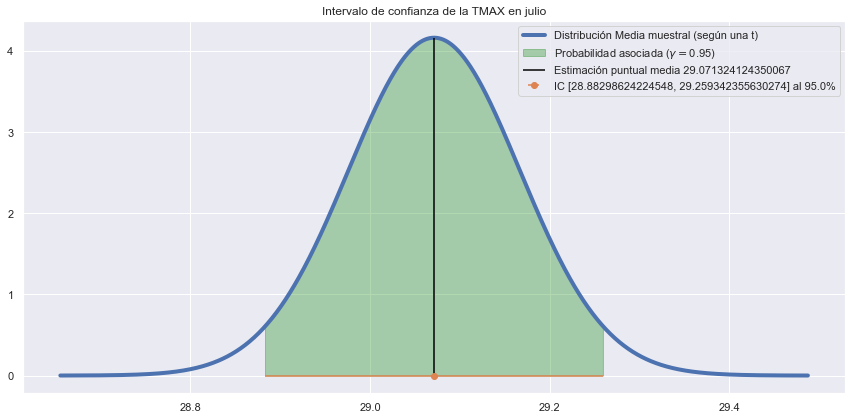

In [113]:
print('Dado que nuestra muestra no sigue una normal, emplearemos bootstrap para estimar el intervalo')
muestra_orig = (x,)  # tiene que ser una secuencia
R = 9999
estadistico = np.mean
nivel_confianza = 0.95
res_BCa = stats.bootstrap(muestra_orig, estadistico, confidence_level = nivel_confianza,  n_resamples = R, method = 'BCA', random_state = 999)

# devuelve como resultado el IC y el SE del estadístico
lim_inf, lim_sup = res_BCa.confidence_interval
SE_BCa = res_BCa.standard_error

print(f'IC {100*nivel_confianza}% estimado según método BCa para la media: [{lim_inf}, {lim_sup}]')
print(f'Error estándar del estimador media muestral, estimado según método BCa: {SE_BCa}')
# Gráficamente
sx = np.std(x, ddof=1)
x_media = np.mean(x)
Xmedia = stats.t(n-1, loc=np.mean(x), scale = sx/np.sqrt(n))  

# puntos para representar la distribución y el intervalo
xs = np.linspace(Xmedia.ppf(0.00001), Xmedia.ppf(1-0.00001), 1000)
xIC = np.linspace(lim_inf, lim_sup, 1000)

plt.figure(1, figsize=(12, 6))
plt.plot(xs, Xmedia.pdf(xs), linewidth = 4, label=f'Distribución Media muestral (según una t)')
plt.fill_between( xIC, Xmedia.pdf(xIC), color="green", alpha=0.3, label=f'Probabilidad asociada ($\gamma=${nivel_confianza})')
plt.vlines(x_media, 0, np.max(Xmedia.pdf(xs)), color='black', label=f'Estimación puntual media {x_media}')
plt.errorbar(x_media, -0.01, xerr = np.array([[x_media - lim_inf], [lim_sup - x_media]]), fmt = 'o', label = f'IC [{lim_inf}, {lim_sup}] al {nivel_confianza*100}%')
plt.title('Intervalo de confianza de la TMAX en julio')
plt.tight_layout()
plt.legend()
plt.savefig('../reports/figures/IC TMAX julio.png', bbox_inches='tight')
plt.show()

In [114]:
# media muestral
x_media = np.mean(x)

# calculamos la desviación típica muestral sx sin sesgo (dividiendo por n-1)
sx = np.std(x, ddof=1)

# Ahora creamos la v.a. MEDIA MUESTRAL como una t de student
#    De la ayuda de scipy.stats.t :
#    To shift and/or scale the distribution use the loc and scale parameters. 
#    Specifically, t.pdf(x, df, loc, scale) is identically equivalent to t.pdf(y, df) / scale with y = (x - loc) / scale.
Xmedia = stats.t(n-1, loc=np.mean(x), scale = sx/np.sqrt(n))  

#Para calcular un IC de la media de X usamos la distribución teórica de la media muestral
gama = 0.95
alfa = 1 - gama
lim_inf2 = Xmedia.ppf(alfa/2)
lim_sup2 = Xmedia.ppf(1-alfa/2)

print(f'El intervalo al {100*gama}% de la media de X es: [{lim_inf2}, {lim_sup2}]')

El intervalo al 95.0% de la media de X es: [28.882800978649207, 29.259847270050926]


#### **4) Distribución TMAX según los meses del año:**

ENERO - KS en normal: máx. dist. = 0.077895 -> p_valor = 0.001
FEBRERO - KS en normal: máx. dist. = 0.077659 -> p_valor = 0.002931
MARZO - KS en normal: máx. dist. = 0.087519 -> p_valor = 0.001
ABRIL - KS en normal: máx. dist. = 0.053631 -> p_valor = 0.124477
MAYO - KS en normal: máx. dist. = 0.037814 -> p_valor = 0.589656
JUNIO - KS en normal: máx. dist. = 0.056861 -> p_valor = 0.075595
JULIO - KS en normal: máx. dist. = 0.060883 -> p_valor = 0.039044
AGOSTO - KS en normal: máx. dist. = 0.059703 -> p_valor = 0.045753
SEPTIEMBRE - KS en normal: máx. dist. = 0.064822 -> p_valor = 0.023116
OCTUBRE - KS en normal: máx. dist. = 0.067401 -> p_valor = 0.013639
NOVIEMBRE - KS en normal: máx. dist. = 0.072458 -> p_valor = 0.006197
DICIEMBRE - KS en normal: máx. dist. = 0.051986 -> p_valor = 0.144756


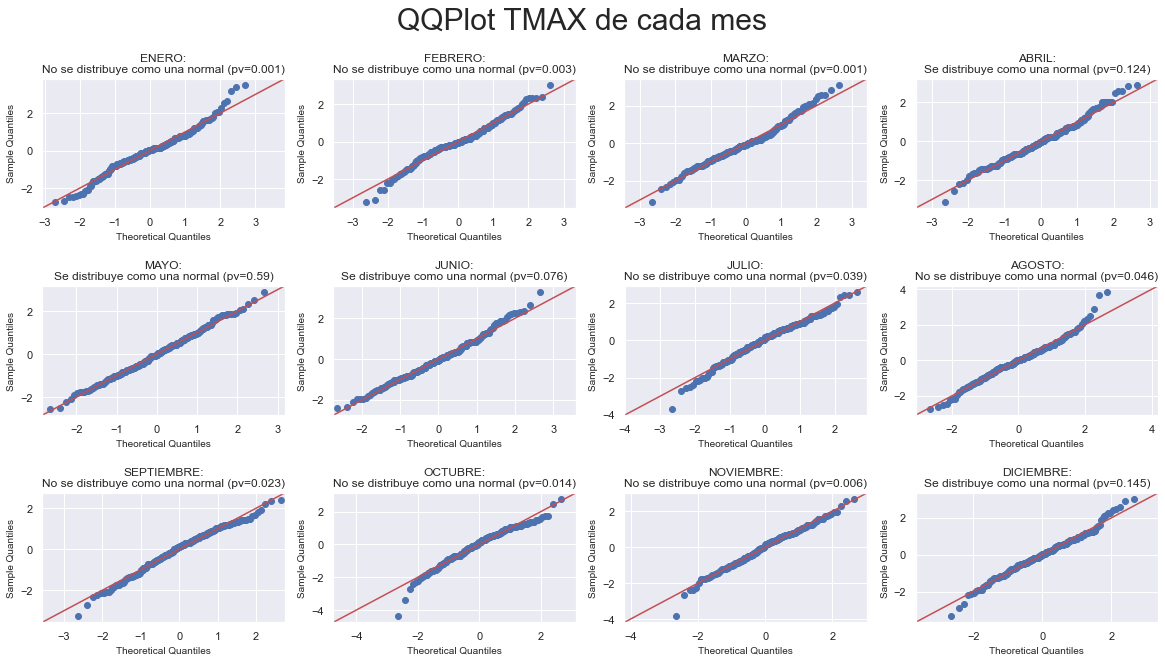

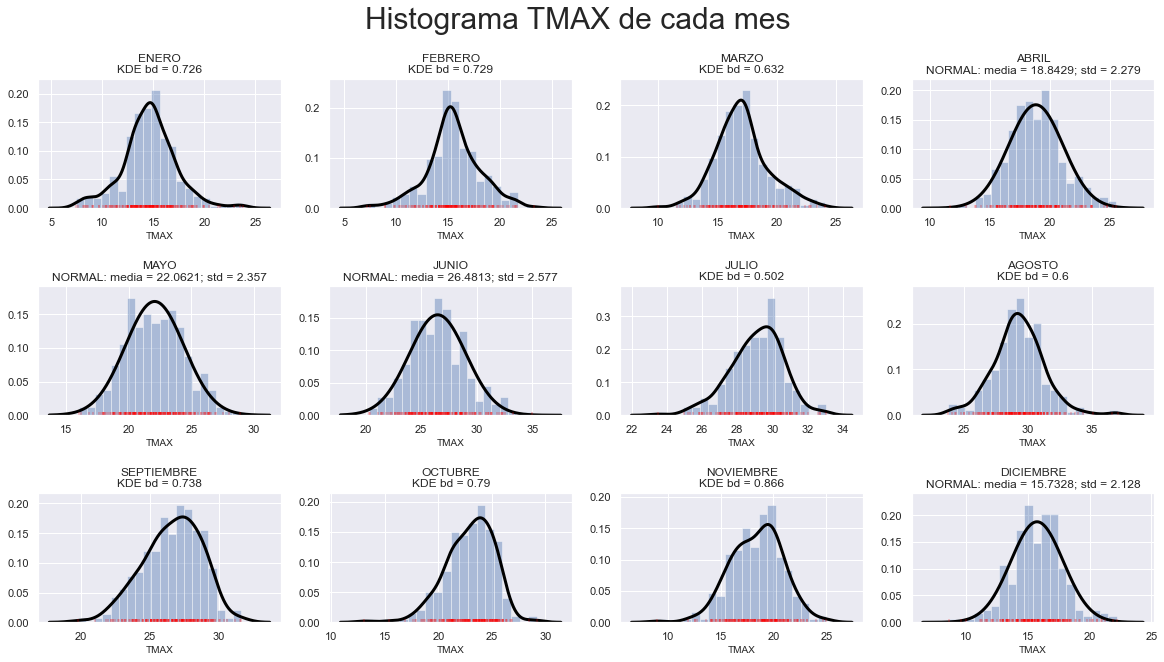

In [115]:
dicc_mes = {'ENERO': 1, 'FEBRERO': 2, 'MARZO': 3, 'ABRIL': 4, 'MAYO': 5, 'JUNIO': 6, 'JULIO': 7, 
            'AGOSTO': 8, 'SEPTIEMBRE': 9, 'OCTUBRE': 10, 'NOVIEMBRE': 11, 'DICIEMBRE': 12}
plt.rcParams['axes.labelsize'] = 10

# nombre de la distribución teórica que se contrasta (norm, uniform, triang, expon, ...)
distribucion_teo = stats.norm
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.subplots_adjust(wspace = 0.2, hspace = 0.6)

fig0, axs0 = plt.subplots(3, 4, figsize=(20, 10))
fig0.subplots_adjust(wspace = 0.2, hspace = 0.6)

dist = getattr(stats, 'norm')
nbins_hist = 20

# genera qqplot de la variable x
for mes in dicc_mes:
    num_MES = dicc_mes[mes]
    current_ax = axs[0, num_MES-1] if num_MES < 5 else axs[1, num_MES-5] if num_MES < 9 else axs[2, num_MES-9]
    current_ax0 = axs0[0, num_MES-1] if num_MES < 5 else axs0[1, num_MES-5] if num_MES < 9 else axs0[2, num_MES-9]
    
    ks = sm.stats.diagnostic.kstest_normal(dataframe[dataframe['MES'] == num_MES]["TMAX"], dist='norm', pvalmethod='table')
    print(f'{mes} - KS en normal: máx. dist. = {round(ks[0], 6)} -> p_valor = {round(ks[1], 6)}')

    sm.qqplot(dataframe[dataframe['MES'] == num_MES]["TMAX"], line='45', fit=True, dist=distribucion_teo,ax = current_ax)
    p_value = ks[1]
    current_ax.set_title(f'{mes}:\n{"Se" if p_value >= 0.05 else "No se"} distribuye como una normal (pv={round(p_value,3)})',
                        fontsize = 12)
    
    kde = KDEUnivariate(dataframe[dataframe['MES'] == num_MES]["TMAX"])
    kde.fit(kernel = 'gau', bw = 'normal_reference', fft = True)
    xs = np.linspace(min(dataframe[dataframe['MES'] == num_MES]["TMAX"]) - np.std(dataframe[dataframe['MES'] == num_MES]["TMAX"]),
                           max(dataframe[dataframe['MES'] == num_MES]["TMAX"]) + np.std(dataframe[dataframe['MES'] == num_MES]["TMAX"]),
                           5000)

    if p_value >= 0.05:
        params = dist.fit(dataframe[dataframe['MES'] == num_MES]["TMAX"])
        pdf_fitted = dist.pdf(xs, loc=params[-2], scale=params[-1])
        current_ax0.hist(dataframe[dataframe['MES'] == num_MES]["TMAX"],nbins_hist, density = True, alpha = 0.4)
        current_ax0.plot(xs, pdf_fitted, color = 'black', linewidth = 3)
        sns.rugplot(dataframe[dataframe['MES'] == num_MES]["TMAX"], height = 0.025, lw = 0.4, color = 'red', ax=current_ax0)
        current_ax0.set_title(f'{mes}\nNORMAL: media = {round(params[0],4)}; std = {round(params[1], 3)}')
    else:
        current_ax0.hist(dataframe[dataframe['MES'] == num_MES]["TMAX"], nbins_hist, density = True, alpha = 0.4)
        current_ax0.plot(xs, kde.evaluate(xs), color = 'black', linewidth = 3)
        sns.rugplot(dataframe[dataframe['MES'] == num_MES]["TMAX"], height = 0.025, lw = 0.4, color = 'red', ax=current_ax0)
        current_ax0.set_title(f'{mes}\nKDE bd = {round(kde.bw, 3)}')
        

fig.suptitle('QQPlot TMAX de cada mes', fontsize = 30)
fig0.suptitle('Histograma TMAX de cada mes', fontsize = 30)
fig.savefig('../reports/figures/QQPlot TMAX de cada mes.png', bbox_inches='tight')
fig0.savefig('../reports/figures/Histograma TMAX de cada mes.png', bbox_inches='tight')
plt.show()

#### **5) Distribución de la demanda de los laborables según los meses del año:**

In [116]:
dataframe_dias_festivos = dataframe[dataframe['FEST'] == 1]
dataframe_sab_dom = dataframe[dataframe['DIASEM'] >= 6]

# Unimos con días festivos
dataframe_no_laborales = pd.concat([dataframe_dias_festivos, dataframe_sab_dom]).sort_values(by='FECHA')
# Quitamos duplicados
dataframe_no_laborales = dataframe_no_laborales.drop_duplicates()
dataframe_laborales = dataframe[dataframe['FECHA'].isin(dataframe_no_laborales['FECHA']) == False]
dataframe_laborales = dataframe_laborales[dataframe_laborales['ANNO'] < 2020]
dataframe_laborales


,FECHA,DEM,TMAX,TMIN,FEST,ANNO,MES,DIA,DIASEM
1,2014-01-02,848.520000,17.9,8.3,0,2014,1,2,4
2,2014-01-03,842.250000,18.0,10.8,0,2014,1,3,5
6,2014-01-07,893.450000,16.8,8.3,0,2014,1,7,2
7,2014-01-08,929.900000,15.3,7.3,0,2014,1,8,3
8,2014-01-09,961.710000,12.9,5.4,0,2014,1,9,4
...,...,...,...,...,...,...,...,...,...
2183,2019-12-24,686.363485,18.2,7.4,0,2019,12,24,2
2185,2019-12-26,796.488156,17.1,9.4,0,2019,12,26,4
2186,2019-12-27,869.119447,15.3,6.9,0,2019,12,27,5
2189,2019-12-30,917.096027,14.9,7.0,0,2019,12,30,1


- Realizamos un qqplot de la demanda para cada mes:

ENERO - KS en normal: máx. dist. = 0.049212 -> p_valor = 0.701998
FEBRERO - KS en normal: máx. dist. = 0.105478 -> p_valor = 0.003558
MARZO - KS en normal: máx. dist. = 0.03429 -> p_valor = 0.98052
ABRIL - KS en normal: máx. dist. = 0.099177 -> p_valor = 0.00838
MAYO - KS en normal: máx. dist. = 0.12336 -> p_valor = 0.001
JUNIO - KS en normal: máx. dist. = 0.120728 -> p_valor = 0.001
JULIO - KS en normal: máx. dist. = 0.103666 -> p_valor = 0.002717
AGOSTO - KS en normal: máx. dist. = 0.058078 -> p_valor = 0.428093
SEPTIEMBRE - KS en normal: máx. dist. = 0.107141 -> p_valor = 0.002235
OCTUBRE - KS en normal: máx. dist. = 0.117055 -> p_valor = 0.001
NOVIEMBRE - KS en normal: máx. dist. = 0.086983 -> p_valor = 0.033283
DICIEMBRE - KS en normal: máx. dist. = 0.062932 -> p_valor = 0.361658


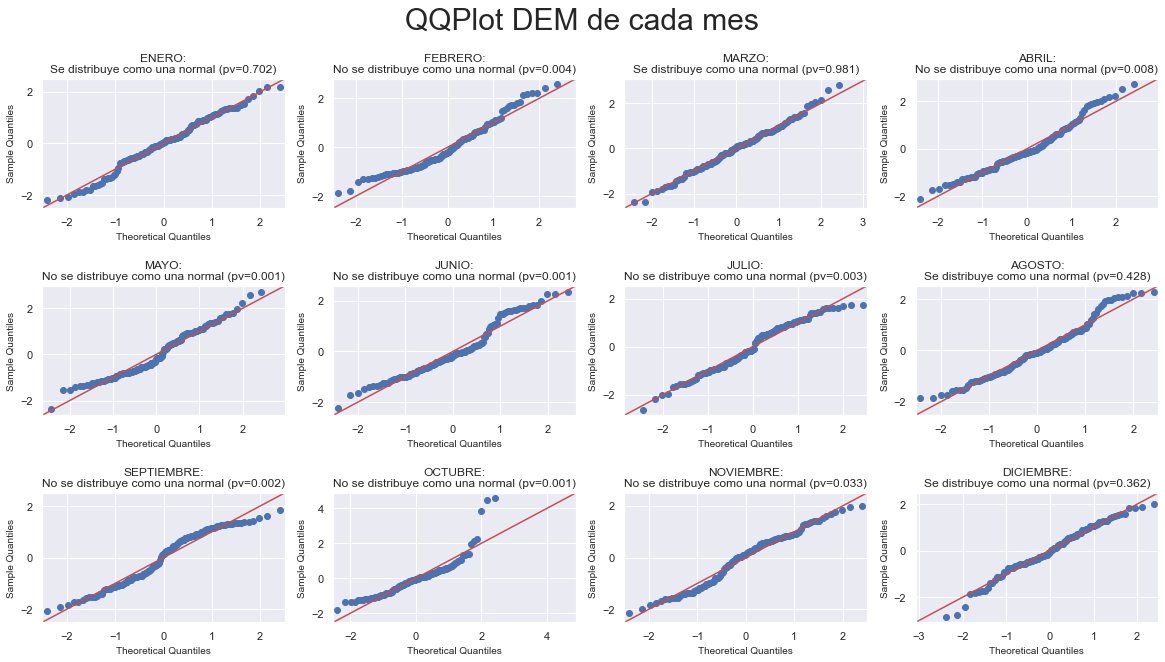

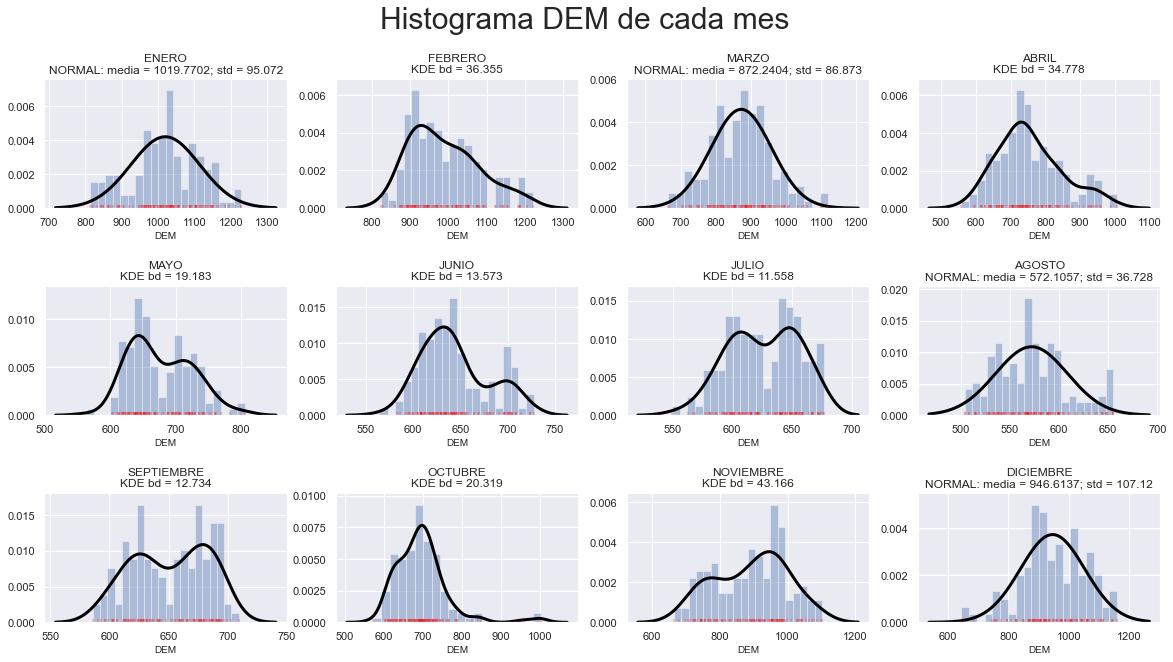

In [117]:
fig1, axs1 = plt.subplots(3, 4, figsize = (20,10))
fig1.subplots_adjust(wspace = 0.2, hspace = 0.6)

fig2, axs2 = plt.subplots(3, 4, figsize = (20,10))
fig2.subplots_adjust(wspace = 0.2, hspace = 0.6)

for mes in dicc_mes:
    num_MES = dicc_mes[mes]
    current_ax1 = axs1[0, num_MES-1] if num_MES < 5 else axs1[1, num_MES-5] if num_MES < 9 else axs1[2, num_MES-9]
    current_ax2 = axs2[0, num_MES-1] if num_MES < 5 else axs2[1, num_MES-5] if num_MES < 9 else axs2[2, num_MES-9]
    array = np.array(dataframe_laborales[dataframe_laborales['MES'] == num_MES]['DEM'])
    
    ks = sm.stats.diagnostic.kstest_normal(dataframe_laborales[dataframe_laborales['MES'] == num_MES]["DEM"], dist='norm', pvalmethod='table')
    print(f'{mes} - KS en normal: máx. dist. = {round(ks[0], 6)} -> p_valor = {round(ks[1], 6)}')

    p_value = ks[1]

    # qqplots
    sm.qqplot(array, line='45', fit=True, dist=stats.norm, ax = current_ax1)
    current_ax1.set_title(f'{mes}:\n{"Se" if p_value >= 0.05 else "No se"} distribuye como una normal (pv={round(p_value,3)})',
                        fontsize = 12)

    kde = KDEUnivariate(dataframe_laborales[dataframe_laborales['MES'] == num_MES]["DEM"])
    kde.fit(kernel = 'gau', bw = 'normal_reference', fft = True)
    xs = np.linspace(min(dataframe_laborales[dataframe_laborales['MES'] == num_MES]["DEM"]) - np.std(dataframe_laborales[dataframe_laborales['MES'] == num_MES]["DEM"]),
                           max(dataframe_laborales[dataframe_laborales['MES'] == num_MES]["DEM"]) + np.std(dataframe_laborales[dataframe_laborales['MES'] == num_MES]["DEM"]),
                           5000)

    # histogramas
    if p_value >= 0.05:
        params = dist.fit(dataframe_laborales[dataframe_laborales['MES'] == num_MES]["DEM"])
        pdf_fitted = dist.pdf(xs, loc=params[-2], scale=params[-1])
        current_ax2.hist(dataframe_laborales[dataframe_laborales['MES'] == num_MES]["DEM"],nbins_hist, density = True, alpha = 0.4)
        current_ax2.plot(xs, pdf_fitted, color = 'black', linewidth = 3)
        sns.rugplot(dataframe_laborales[dataframe_laborales['MES'] == num_MES]["DEM"], height = 0.025, lw = 0.4, color = 'red', ax=current_ax2)
        current_ax2.set_title(f'{mes}\nNORMAL: media = {round(params[0],4)}; std = {round(params[1], 3)}')
    else:
        current_ax2.hist(dataframe_laborales[dataframe_laborales['MES'] == num_MES]["DEM"], nbins_hist, density = True, alpha = 0.4)
        current_ax2.plot(xs, kde.evaluate(xs), color = 'black', linewidth = 3)
        sns.rugplot(dataframe_laborales[dataframe_laborales['MES'] == num_MES]["DEM"], height = 0.025, lw = 0.4, color = 'red', ax=current_ax2)
        current_ax2.set_title(f'{mes}\nKDE bd = {round(kde.bw, 3)}')

fig1.suptitle('QQPlot DEM de cada mes', fontsize = 30)
fig2.suptitle('Histograma DEM de cada mes', fontsize = 30)
fig1.savefig('../reports/figures/QQPlot DEM de cada mes.png', bbox_inches='tight')
fig2.savefig('../reports/figures/Histograma DEM de cada mes.png', bbox_inches='tight')
plt.show()

#### **6) ANOVA de la demanda de los laborales con los meses:**

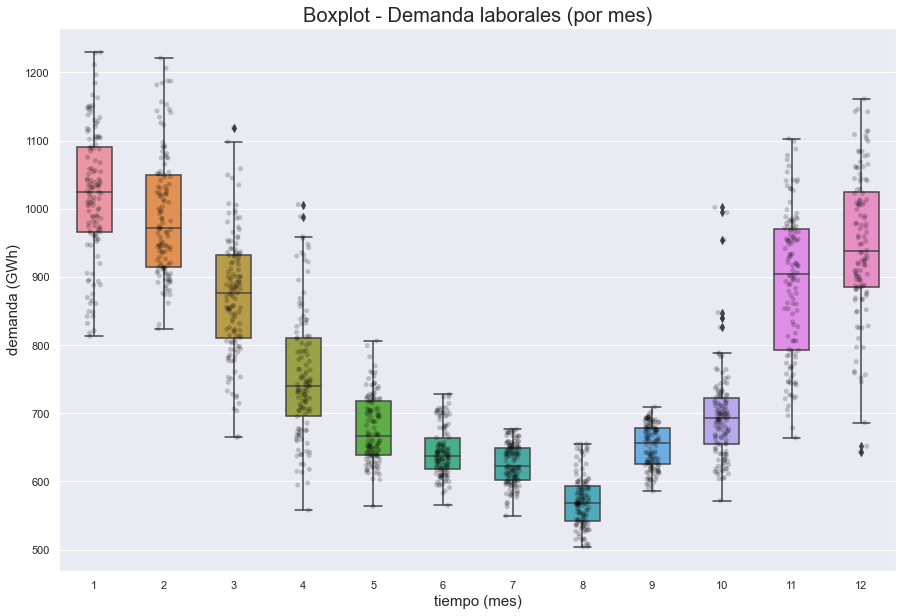

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,33924380.50085,11,3084034.590986,557.51304,0.0,2.001333
Within Groups,8292125.061108,1499,5531.771222,,,
Total,42216505.561958,1510,27957.950703,,,


In [118]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)
# calculate SSTR and update anova table
x_bar = dataframe_laborales['DEM'].mean()
SSTR = dataframe_laborales.groupby('MES').count() * (dataframe_laborales.groupby('MES').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['DEM'].sum()

# calculate SSE and update anova table
SSE = (dataframe_laborales.groupby('MES').count() - 1) * dataframe_laborales.groupby('MES').std()**2
anova_table['SS']['Within Groups'] = SSE['DEM'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['DEM'].sum() + SSE['DEM'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = dataframe_laborales['MES'].nunique() - 1
anova_table['df']['Within Groups'] = dataframe_laborales.shape[0] - dataframe_laborales['MES'].nunique()
anova_table['df']['Total'] = dataframe_laborales.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# DEMANDA / MES
fig3 = plt.figure(1, figsize=(15,10))

DEM_boxplot = sns.boxplot(y='DEM', x='MES', 
                 data=dataframe_laborales, 
                 width=0.5)

if(len(dataframe_laborales) <= maxScatter):
    DEM_boxplot=sns.stripplot(y='DEM', x='MES', 
                       data=dataframe_laborales, 
                       jitter=True, 
                       marker='o', 
                       alpha=0.2,
                       color='black')

plt.title("Boxplot - Demanda laborales (por mes)", fontsize = 20)
plt.xlabel("tiempo (mes)", fontsize = 15)
plt.ylabel("demanda (GWh)", fontsize = 15)
plt.savefig('../reports/figures/Boxplot - Demanda laborales (por mes).png', bbox_inches='tight')
plt.show()

# Final ANOVA Table
anova_table